# Timeseries Circuits
*TS utilities in* ***PennyLane***

**By:** Jacob Cybulski<br>
**Date:** August 2024<br>
**Aims:** The goal of this notebook is to test some of the QuTSAE circuits and their elements.

**References:**
- https://docs.pennylane.ai/en/stable/introduction/interfaces.html
- https://docs.pennylane.ai/en/stable/introduction/interfaces/torch.html
- https://pennylane.ai/qml/glossary/circuit_ansatz/
- https://docs.pennylane.ai/en/stable/introduction/templates.html
- Creation of complex circuits
  + https://pennylane.ai/qml/demos/function_fitting_qsp/
  + https://pennylane.ai/qml/demos/tutorial_learning_few_data/

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '.',
 '..']

In [3]:
### General libraries

import matplotlib.pyplot as plt
import pylab
import math
from IPython.display import clear_output

from matplotlib import set_loglevel
set_loglevel("error")

%matplotlib inline

In [4]:
### PennyLane and Torch

import pennylane as qml
from pennylane import numpy as np
import torch

In [5]:
### Libraries used in QAE development

from utils.Circuits import *

## Settings

In [6]:
device = 'lightning.qubit'
# device = 'lightning.gpu'

## Utilities

In [7]:
shots_list = [5, 10, 1000]
dev = qml.device(device, wires=2, shots=shots_list)

@qml.qnode(dev, interface='torch')
def circuit_torch(phi, theta, msg='hello'):
    print(msg)
    qml.RX(phi[0], wires=0)
    qml.RY(phi[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.PhaseShift(theta, wires=0)
    return qml.expval(qml.PauliZ(0))

phi = torch.tensor([0.5, 0.1], requires_grad=True)
theta = torch.tensor(0.2, requires_grad=True)
circuit_torch(phi, theta)

hello


(tensor(1., dtype=torch.float64, grad_fn=<ExecuteTapesBackward>),
 tensor(0.6000, dtype=torch.float64, grad_fn=<ExecuteTapesBackward>),
 tensor(0.8800, dtype=torch.float64, grad_fn=<ExecuteTapesBackward>))

In [8]:
print(qml.draw(circuit_torch)(phi, theta, msg='hi'))

hi
0: ──RX(0.50)─╭●──Rϕ(0.20)─┤  <Z>
1: ──RY(0.10)─╰X───────────┤     


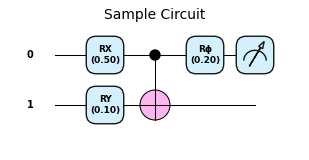

In [9]:
draw_circuit(circuit_torch, scale=0.5, title='Sample Circuit', style='pennylane')(phi, theta, msg='\n')

## Building and training a Quantum Autoencoder

### Sequence encoder
The sequence is encoded as a series of angle rotations

test_sequence_encoder(range(0, 5), [ 0.52359878 -1.57079633  0.39269908], [1]): tensor([1., 0.], dtype=torch.float64)



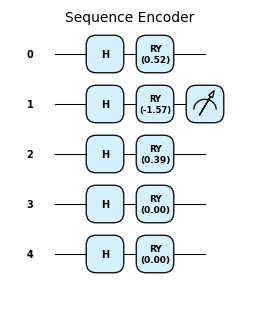

In [10]:
### Sequence encoder wrapper
def test_sequence_encoder(n_wires, data, meas_wires):
    sequence_encoder(n_wires, data)
    return qml.probs(wires=meas_wires)
    
### Testing the sequence encoder
shots = 1
wires = range(5)
n_wires = len(wires)
seq_data = np.array([np.pi/6, -np.pi/2, np.pi/8], requires_grad=False)
meas_wires = [1]

dev = qml.device(device, wires=n_wires, shots=shots)
seq_qc = qml.QNode(test_sequence_encoder, dev, interface='torch')

print(f'test_sequence_encoder({wires}, {seq_data}, {meas_wires}): {seq_qc(wires, seq_data, meas_wires)}\n')
draw_circuit(seq_qc, scale=0.5, title='Sequence Encoder')(wires, seq_data, meas_wires)

**Figure: Example of encoding for a sample sequence window**

### Creation of an ansatze

The selected ansatze are basic and strongly entangled layers ansatze. 

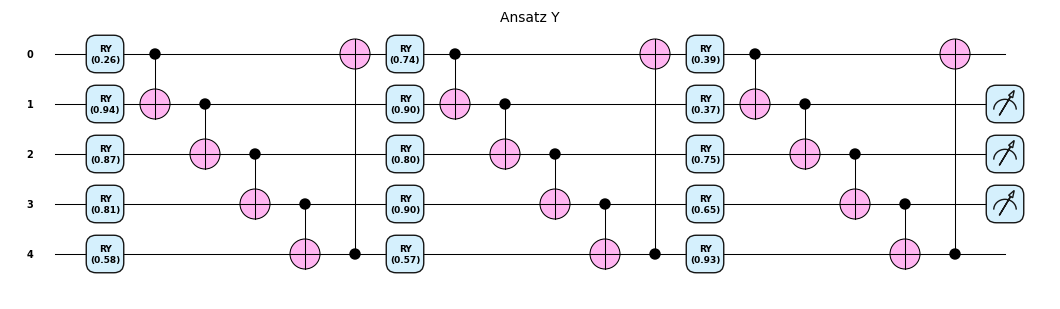

In [11]:
### Ansatz Ry wrapper
def test_ansatz_y(wires, weights, meas_wires):
    ansatz_y(wires, weights)
    return qml.probs(wires=meas_wires)
    
### Testing the Ry ansatz
shots = 1
n_wires = 5
n_layers = 3

dev = qml.device(device, wires=n_wires, shots=shots)

shape = ansatz_y_shape(n_wires, n_layers)
wires = range(n_wires)
weights = torch.rand(shape, requires_grad=True)
meas_wires = [1, 2, 3]

ansatz_y_qc = qml.QNode(test_ansatz_y, dev, interface='torch')
draw_circuit(ansatz_y_qc, scale=0.5, title='Ansatz Y', expansion_strategy='device')(wires, weights, meas_wires) # expansion_strategy='device'/'gradient'

**Figure: Sample Y rotation ansatz**

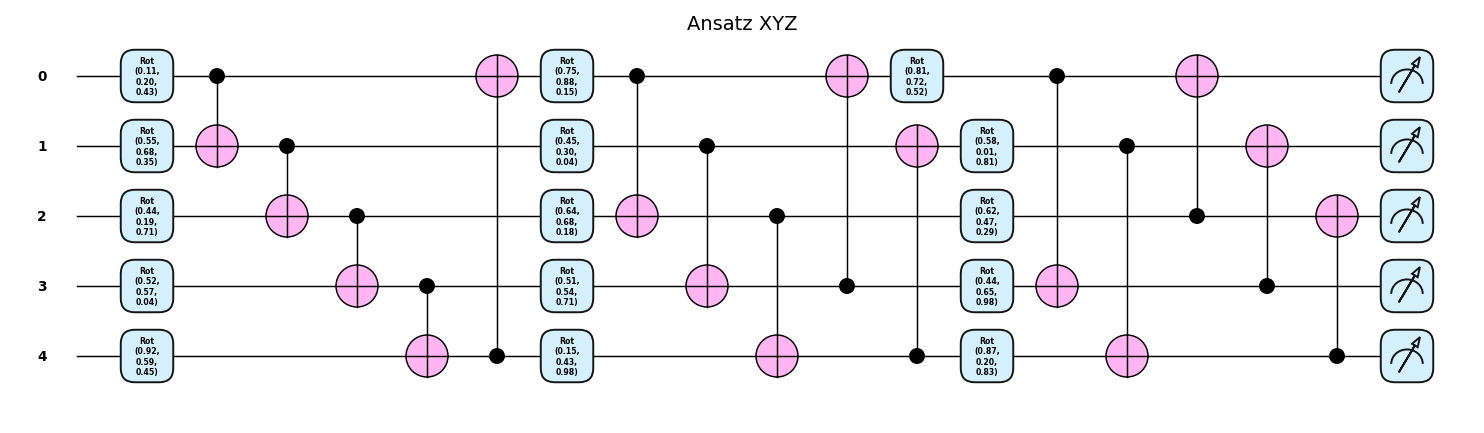

In [25]:
### Ansatz Rxyz wrapper
def test_ansatz_xyz(wires, weights, meas_wires):
    ansatz_xyz(wires, weights)
    return qml.probs(wires=meas_wires)
    
### Testing the Rxyz ansatz
shots = 1
n_wires = 5
n_layers = 3

dev = qml.device(device, wires=n_wires, shots=shots)

shape = ansatz_xyz_shape(n_wires, n_layers)
wires = range(n_wires)
weights = torch.rand(shape, requires_grad=True)
meas_wires = range(n_wires)

ansatz_xyz_qc = qml.QNode(test_ansatz_xyz, dev, interface='torch')
draw_circuit(ansatz_xyz_qc, scale=0.7, title='Ansatz XYZ', expansion_strategy='device')(wires, weights, meas_wires) # expansion_strategy='device'/'gradient'

**Figure: Sample XYZ rotation ansatz**

### Swap Test
For two qubts, it returns a squared inner product between their states. In this implementation, it estimates the overlap between the states of all participating qubits. 
The repeated measurement of 1 indicates that the quantum states are identical. For two qubits, if the measurement returns 0.5 then the two states are orthogonal.
However, orthogonality of the remaining states is no longer possible, so the measurements will be further away from 1, possibly confusing the outcome.

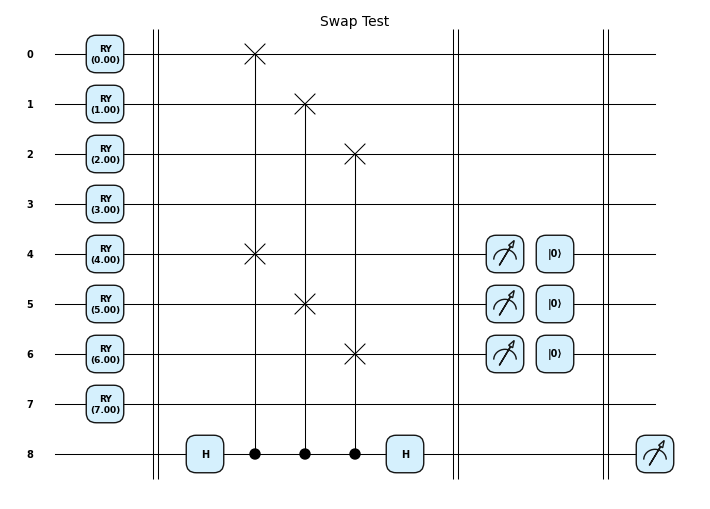

In [13]:
### Swap test wrapper
def test_swap_test(data_wires, comp_wires, test_wire):
    for w in range(0, test_wire): qml.RY(w, w)
    qml.Barrier(data_wires+comp_wires+[test_wire])
    swap_test(data_wires, comp_wires, test_wire)
    qml.Barrier(data_wires+comp_wires+[test_wire])
    for w in comp_wires: qml.measure(w, reset=True)
    qml.Barrier(data_wires+comp_wires+[test_wire])
    return qml.probs(wires=test_wire)
    
### Testing swap test
shots = 1
n_wires = 9
data_wires = [0, 1, 2]
trash_wires = [4, 5, 6]
aux_wire = 8

dev = qml.device(device, wires=n_wires, shots=shots)

swap_qc = qml.QNode(test_swap_test, dev, interface='torch')
draw_circuit(swap_qc, scale=0.5, title='Swap Test', expansion_strategy='gradient')(data_wires, trash_wires, aux_wire) # expansion_strategy='device'/'gradient'

### Half-QAE Encoder/Decoder$^\dagger$:<br/>Pure Input + Encoder/Decoder$^\dagger$ + Swap Test
It creates a encoder/decoder$^\dagger$ with input to be trained with the use of swap space on trash qubits.<br/>
To create a decoder$^\dagger$ pass inverse=True, later in testing to be reversed again.

Weights:
tensor([[0.2953, 0.6393, 0.7915, 0.4195, 0.3767, 0.0123, 0.5891],
        [0.0694, 0.3449, 0.3609, 0.0813, 0.2620, 0.4782, 0.0981]],
       requires_grad=True)


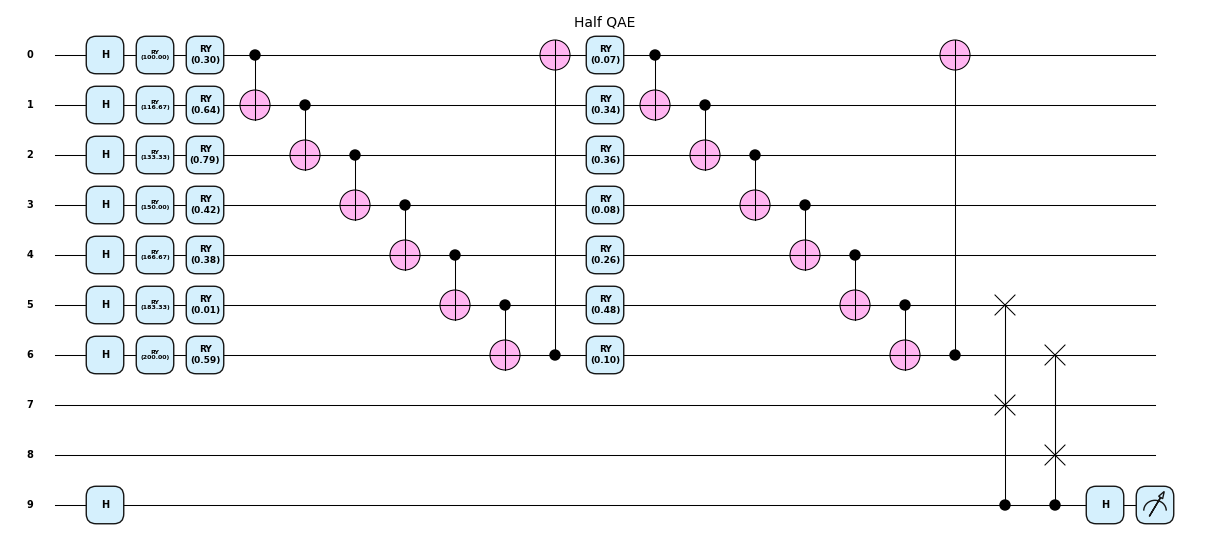

In [14]:
### Half QAE with swap test wrapper
def test_half_qae_enc_with_swap(latent_wires, trash_wires, comp_wires, test_wire, data, weights, inverse=False):
    half_qae_enc_with_swap(latent_wires, trash_wires, comp_wires, test_wire, data, weights, inverse=inverse)
    return qml.probs(wires=test_wire)
    
### Testing half QAE
shots = 1
latent_wires = [0, 1, 2, 3, 4]
trash_wires = [5, 6]
comp_wires = [7, 8]
test_wire = 9

n_latent_wires = len(latent_wires)
n_trash_wires = len(trash_wires)
n_weights, n_inputs, n_wires = half_qae_enc_with_swap_shape(n_latent_wires, n_trash_wires, n_layers=2)
data = torch.linspace(100, 200, n_inputs, requires_grad=False)
weights = torch.rand(n_weights, requires_grad=True)
print(f'Weights:\n{weights}')

dev = qml.device(device, wires=n_wires, shots=shots)

test_half_qae_qc = qml.QNode(test_half_qae_enc_with_swap, dev, interface='torch')
draw_circuit(test_half_qae_qc, scale=0.5, title='Half QAE', expansion_strategy='device') \
    (latent_wires, trash_wires, comp_wires, test_wire, data, weights, inverse=False) # expansion_strategy='device'/'gradient'

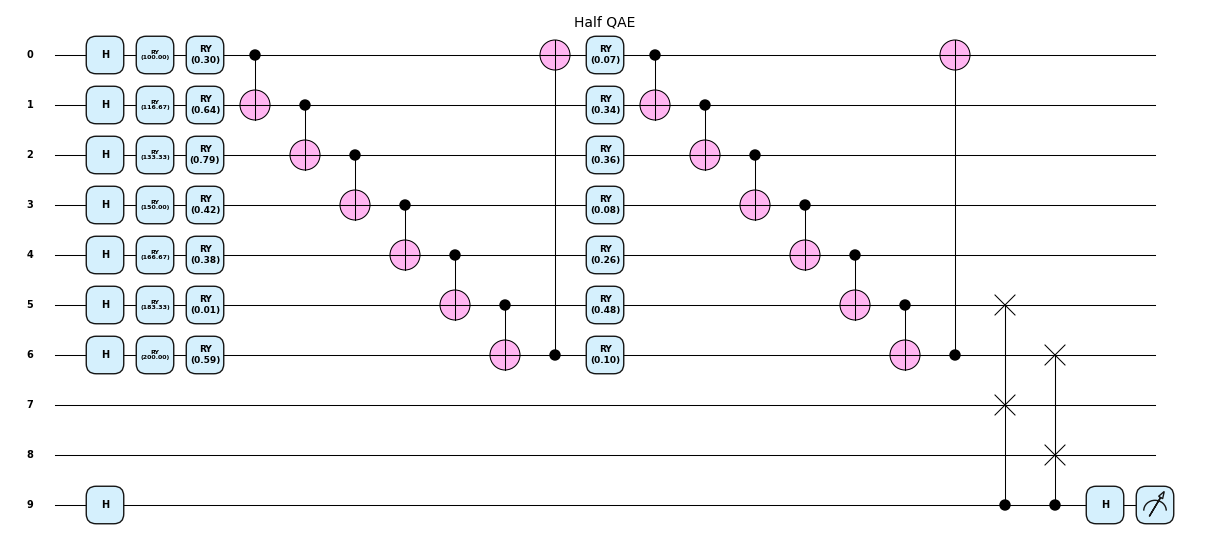

In [15]:
test_half_qae_qc = qml.QNode(test_half_qae_enc_with_swap, dev, interface='torch')
draw_circuit(test_half_qae_qc, scale=0.5, title='Half QAE', expansion_strategy='device') \
    (latent_wires, trash_wires, comp_wires, test_wire, data, weights, inverse=True) # expansion_strategy='device'/'gradient'

**Figure: Half-QAE structure for training using only Encoder and the Swap Test**<br/>
The swap test compares the states of qubits in the trash space with qubits initialised with $\lvert 0 \rangle$

### Training full-QAE with Y (PL basic ent) layer or XYZ (PL strong ent) rotations layers:<br/>Noisy Input + Encoder + Latent Space + Decoder$^\dagger$ + Pure Input$^\dagger$
It creates a full QAE to train its encoder optionally using the previously trained decoder$^\dagger$ by converging the output to $\vert 0 \rangle^n$.<br/>
The encoder is to be trained with noisy input trough the latent space, then the decoder (possibly with $^\dagger$), pure data$^\dagger$, to result in $\vert 0 \rangle^n$.<br/>
For training, all qubits of this full-QAE will be measured.

In [16]:
### Full-QAE wrapper with a static data structure and variant input and weights only
def full_qae_static(wires, n_latent, n_trash, n_extra, n_layers=1, rot='Ry', add_outseq=True, invert_dec=True):
    def _full_qae_static(data, weights):
        nonlocal wires, n_latent, n_trash, n_extra, n_layers, rot, add_outseq, invert_dec
        latent_wires = wires[0:n_latent]
        trash_wires = wires[n_latent:n_latent+n_trash]
        data_wires = latent_wires + trash_wires
        full_qae(wires, n_latent, n_trash, n_extra, data, weights, \
                 n_layers=n_layers, rot=rot, add_outseq=add_outseq, invert_dec=invert_dec)
        return qml.probs(wires=data_wires)
    return _full_qae_static
    
### Testing full-QAE

# Define full-QAE parameters
n_latent = 3; n_trash = 2; n_extra = 0; n_layers=2
wires = list(range(n_latent+n_trash+n_extra))
rot = 'Ry'

n_weights, n_inputs, n_wires = full_qae_shape(n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot)
print(f'Full-QAE shape: {(n_weights, n_inputs, n_wires)}\n')

data = torch.linspace(100, 200, n_inputs, requires_grad=False)
weights = torch.rand(n_weights, requires_grad=True)

print(f'Data ({data.shape}): \n{data}\n')
print(f'Weights ({weights.shape}): \n{weights}\n')

Full-QAE shape: (20, 5, 5)

Data (torch.Size([5])): 
tensor([100., 125., 150., 175., 200.])

Weights (torch.Size([20])): 
tensor([0.5935, 0.8865, 0.1292, 0.4680, 0.6265, 0.7774, 0.8264, 0.8952, 0.9173,
        0.3886, 0.4215, 0.4153, 0.6026, 0.2316, 0.4753, 0.9201, 0.3756, 0.0080,
        0.6940, 0.1456], requires_grad=True)



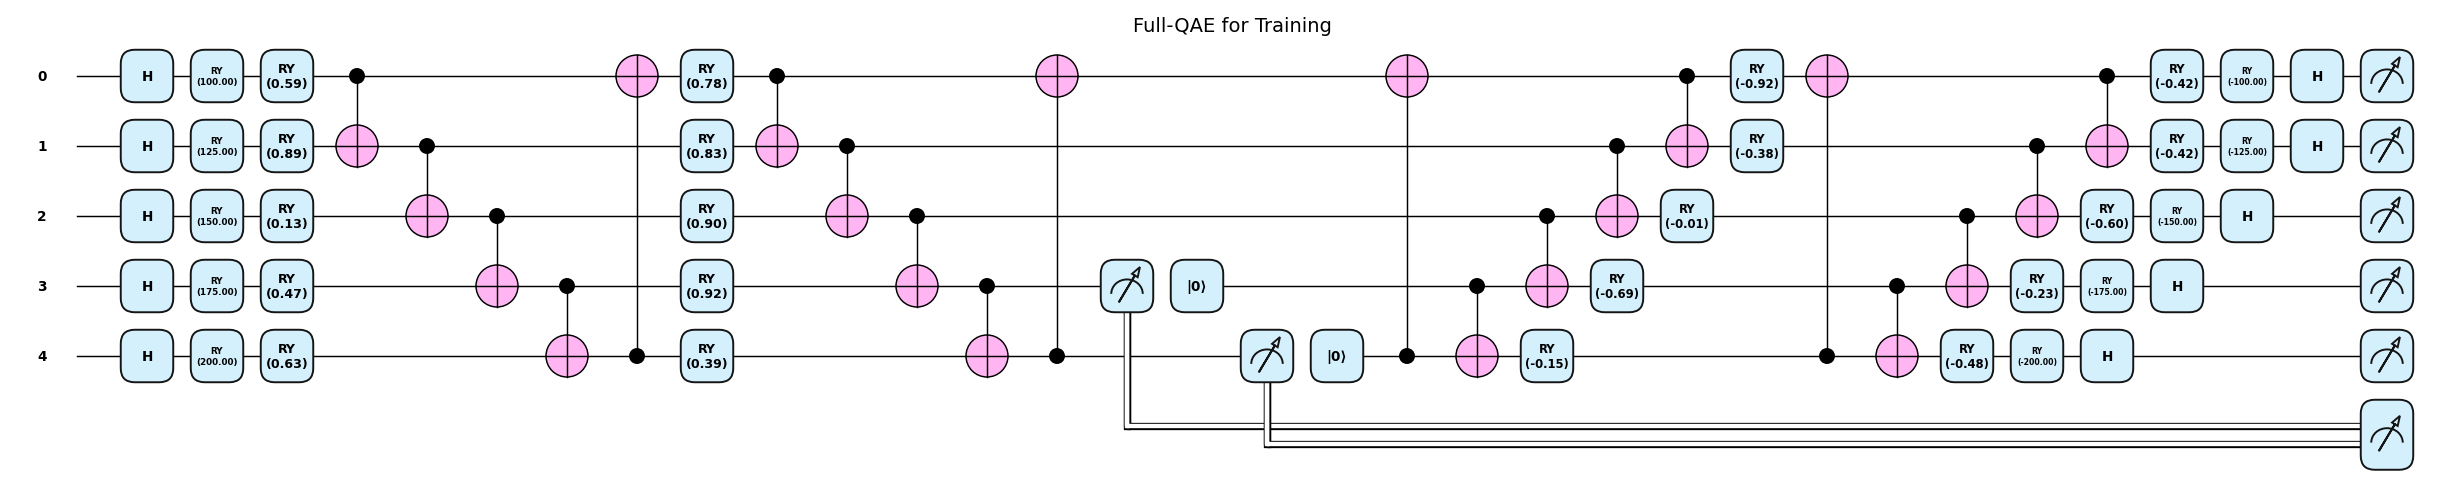

In [17]:
### Testing full-QAE for training

# Define a static full-QAE
train_qae_static = full_qae_static(wires, n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot, add_outseq=True)

# Create and draw a full-QAE
dev = qml.device(device, wires=n_wires, shots=shots)
train_qae_qc = qml.QNode(train_qae_static, dev, interface='torch', expansion_strategy='gradient')
dc = draw_circuit(train_qae_qc, scale=0.7, title='Full-QAE for Training', expansion_strategy='device')
dc(data, weights) # expansion_strategy='device'/'gradient'

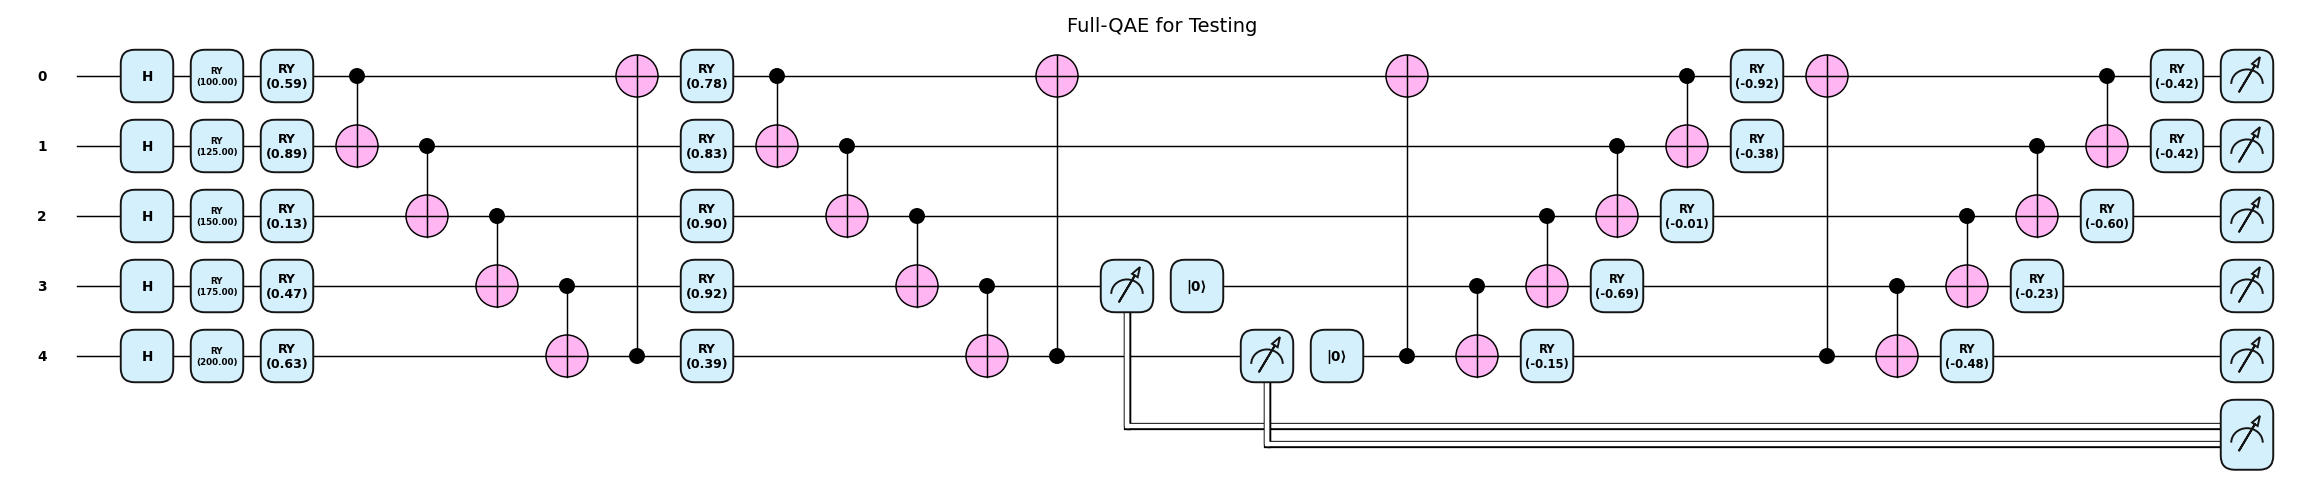

In [18]:
### Testing full-QAE for testing/validation

# Define a static full-QAE
test_qae_static = full_qae_static(wires, n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot, add_outseq=False)

# Create and draw a full-QAE
dev = qml.device(device, wires=n_wires, shots=shots)
test_qae_qc = qml.QNode(test_qae_static, dev, interface='torch', expansion_strategy='gradient')
draw_circuit(test_qae_qc, scale=0.7, title='Full-QAE for Testing', expansion_strategy='device') (data, weights) # expansion_strategy='device'/'gradient'

***

### Full-QAE:<br/>Noisy Input + Encoder + Latent Space + Decoder$^\dagger$ + Pure Input + Swap Test
The encoder is to be trained with noisy input. Both the encoder and decoder need to be trained together. They converge onto the pure data encoded in separate qubits via a swap test.

In [19]:
# sample_lat=5; sample_trash=3

# sample_qae, pure_out_params, decoder_params, noisy_in_params, encoder_params = \
#     full_qae_encoder_with_swap(sample_lat, sample_trash, reps=1, ent='sca',
#                   pure_seq_name='Pure Input', pure_seq_label='P', 
#                   noisy_seq_name='Noisy Input', noisy_seq_label='N', 
#                   enc_name='Encoder', enc_label='X',
#                   dec_name='Decoder', dec_label='Y')

# print()
# print(f'\nExample autoencoder circuit (with {sample_lat} latent and {sample_trash} trash qubits):')
# print(f'\nPure out-parameters:\n{pure_out_params}')
# print(f'\nNoisy in-parameters:\n{noisy_in_params}')
# print(f'\nEncoder parameters:\n{encoder_params}')
# print(f'\nDecoder parameters:\n{decoder_params}\n\n')

# print('\n')
# display(sample_qae.decompose().draw("latex", style="iqp", scale=1)) #, cregbundle=False))
# print('\n')

### Half-QAE Encoder with Sidekick Decoder$^\dagger$:<br/>Noisy Input + Encoder + Swap Test + Sidekick (Decoder$^\dagger$ + Pure Input)
It creates an encoder using the previously trained sidekick decoder$^\dagger$ by converging their common latent space.<br/>
The encoder is to be trained with noisy input and ensuring its latent space converges with that produced by the decoder$^\dagger$ from pure data.

In [20]:
# ### Test an encoder circuit
# sample_lat=5; sample_trash=3
# sample_aec, sample_pure_in_params, sample_dec_params, sample_noisy_in_params, sample_enc_params = \
#     half_qae_encoder_with_sidekick(sample_lat, sample_trash, reps=1, ent='sca', 
#                   pure_seq_name='Pure In', pure_seq_label='I', noisy_seq_name='Noisy In', noisy_seq_label='N', 
#                   enc_name='Enc', enc_label='X', dec_name='Dec', dec_label='Y')

# ### Print all parameters
# print()
# print(f'\nExample autoencoder circuit (with {sample_lat} latent and {sample_trash} trash qubits):')
# print(f'\nPure In params:\n{sample_pure_in_params}')
# print(f'\nDecoder params:\n{sample_dec_params}')
# print(f'\nNoisy In params:\n{sample_noisy_in_params}')
# print(f'\nEncoder params:\n{sample_enc_params}')

# ### Assign decoder parameters to their optimum (simulated)
# dec_param_vals = np.linspace(0, 0.5*np.pi, num=len(sample_dec_params))
# sample_aec.assign_parameters({k:v for (k,v) in zip(sample_dec_params,dec_param_vals) }, inplace=True)

# ### Display the circuit with assigned decoder parameters
# print('\n')
# display(sample_aec.decompose().draw("latex", style="iqp", scale=1))
# # display(sample_aec.draw("latex", style="iqp", scale=1, cregbundle=False))
# print('\n')

**Figure: Half-QAE with Sidekick structure for training the Encoder with the Swap Test and previously trained Sidekick Decoder$^\dagger$**<br/>
The swap test compares the states of qubits in the latent space of both the Encoder and Decoder$^\dagger$

***

### Full-QAE Stacked Encoder and (optionally) previously trained Decoder$^\dagger$:<br/>Noisy Input + Encoder + Latent Space + Decoder + Pure Input$^\dagger$
It creates a full QAE to train its encoder using the previously trained decoder$^\dagger$ by converging the output to $\vert 0 \rangle^n$.<br/>
The encoder is to be trained with noisy input trough the latent space, then the decoder (no $^\dagger$), pure data$^\dagger$, to result in $\vert 0 \rangle^n$.<br/>
For training, all qubits of this Full-QAE will be measured.

In [21]:
# ### Test an encoder circuit
# sample_lat=5; sample_trash=3
# sample_aec, sample_pure_in_params, sample_dec_params, sample_noisy_in_params, sample_enc_params = \
#     full_qae_stacked(sample_lat, sample_trash, reps=1, ent='sca', 
#                   pure_seq_name='Pure In', pure_seq_label='P', noisy_seq_name='Noisy In', noisy_seq_label='N', 
#                   enc_name='Enc', enc_label='X', dec_name='Dec', dec_label='Y')

# ### Print all parameters
# print()
# print(f'\nExample autoencoder circuit (with {sample_lat} latent and {sample_trash} trash qubits):')
# print(f'\nPure In params:\n{sample_pure_in_params}')
# print(f'\nDecoder params:\n{sample_dec_params}')
# print(f'\nNoisy In params:\n{sample_noisy_in_params}')
# print(f'\nEncoder params:\n{sample_enc_params}')

# ### Assign decoder parameters to their optimum (simulated)
# dec_param_vals = np.linspace(0, 0.5*np.pi, num=len(sample_dec_params))
# # sample_aec.assign_parameters({k:v for (k,v) in zip(sample_dec_params,dec_param_vals) }, inplace=True)

# ### Display the circuit with assigned decoder parameters
# print('\n')
# display(sample_aec.decompose().draw("latex", style="iqp", scale=1))
# print('\n')

**Figure: Full-QAE Stacked Encoder and previously trained (Sidekick) Decoder$^\dagger$**<br/>
All qubits are being measured to check for the output to be $\vert 0 \rangle^n$ and $cost = P(1-\lvert 0 \rangle)^n$.

### Half-QAE Encoder: Input + Encoder without a Swap Test
It assesses the state of all trash qubits to be $\lvert 0 \rangle$ by their direct measurement and estimating the probability $P(\lvert 0 \rangle)^n$ (where $n$ is the number of qubits in the trash space. This approach to measuring qubit similarity is not as nuanced as what's is provided by swap test, as we miss on the state proximity determined by their inner product. However, the measurement is fast(er) and does not need additional qubits. The circuit training needs the cost function $cost = P(1-\lvert 0 \rangle)^n$, which needs to be minimised.

In [22]:
# ### Building partial QAE for its training without a swap test
# sample_ae, _, _ = half_qae_encoder(5, 3, reps=1, ent='sca')
# print('\nExample autoencoder circuit:\n')
# display(sample_ae.decompose().draw("latex", style="iqp", scale=1))

**Figure: Half-QAE structure for training using only Encoder and measurements of qubit states**<br/>
The $\lvert 0 \rangle$ state of trash qubits is determined by the cost function: $cost = 1-P(\lvert 0 \rangle^n)$ (with n - number of qubits in trash space)

***

### Full-QAE: Input + Encoder + Decoder + Output + No Swap Test
*Note: Position of the output block may vary<br/>Note: Decoder could be an inverse of encoder or become an independent block*

In [23]:
# ### Test a full encoder circuit for training
# sample_tqae, in_out_params, enc_params, dec_params, all_weight_params = \
#     train_qae(5, 3, reps=1, ent='sca', in_seq_label='N', in_seq_name='Noisy Input')
# print('\nExample autoencoder circuit'+
#       '\nNote: Decoder is either an inverse of the encoder or an independent decoder block):')

# print(f'\nIn/Out  parameters:\n{in_out_params}')
# print(f'\nEncoder parameters:\n{enc_params}')
# print(f'\nDecoder parameters:\n{dec_params}')
# print(f'\nWeight parameters:\n{all_weight_params}\n\n')

# # display(sample_tqae.decompose().draw("latex", style="iqp", scale=0.8, cregbundle=False))
# display(sample_tqae.decompose().draw("latex", style="iqp", scale=0.8, fold=-1)) # latex, mpl, 
# print()

## Software used

In [24]:
!pip list | grep -e PennyLane -e torch -e jax

jax                       0.4.28
jax-cuda12-pjrt           0.4.28
jax-cuda12-plugin         0.4.28
jaxlib                    0.4.28
PennyLane                 0.36.0
PennyLane_Lightning       0.36.0
PennyLane_Lightning_GPU   0.36.0
PennyLane-Rigetti         0.36.0
torch                     2.3.1+cu121
torchaudio                2.3.1+cu121
torchsummary              1.5.1
torchvision               0.18.1+cu121
